In [1]:
import numpy as np
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from distance_matching_functional import DistanceMatching
from distance_matching_lowrank import DistanceMatching as DMR_LR
import functions
import utils

sys.path.append("../baselines/")
from baselines import baselines 

import matplotlib.pyplot as plt
%matplotlib inline

remake_delta_Z = False

refit_mixture = False
refit_vc      = False

In [2]:
# Load Data
X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy")
Z_train = np.load("Z_train.npy")
X_test  = np.load("X_test.npy")
Y_test  = np.load("Y_test.npy")
Z_test  = np.load("Z_test.npy")
delta_Z = np.load("delta_Z.npy")
K = Z_train.shape[1]
print(K)

11


In [3]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=5)
#X_train = pca.fit_transform(X_train)
#X_test  = pca.transform(X_test)
X_train = X_train[:, :5]
X_test  = X_test[:, :5]

X_train = np.hstack((X_train, np.expand_dims(np.ones_like(X_train[:, 0]), 1)))
X_test  = np.hstack((X_test,  np.expand_dims(np.ones_like(X_test[:, 0]), 1)))

In [4]:
desired_Z_features = 2
if Z_train.shape[1] > desired_Z_features:
    print("Reducing Z size...", end=' ')
    from sklearn.decomposition import PCA
    pca = PCA(n_components=desired_Z_features)
    Z_train = pca.fit_transform(Z_train)
    Z_test  = pca.transform(Z_test)
    print("Finished.")
K = Z_train.shape[1]

dZ = [
    lambda x,y: functions.safe_wrapper(x, y, functions.abs_diff),
    lambda x,y: functions.safe_wrapper(x, y, functions.abs_diff)
]

from sklearn.preprocessing import normalize
Z_train, norms = normalize(Z_train, norm='l1', axis=0, return_norm=True)
Z_test /= norms
print(Z_train.shape)
print(Z_test.shape)

Reducing Z size... Finished.
(2135, 2)
(712, 2)


In [5]:
# Linear Regression baseline
sys.path.append("../")

from sklearn.linear_model import LinearRegression as LR
lr = LR()
lr_coef = []
for i in range(Y_train.shape[1]):
    lr.fit(X_train, Y_train[:, i])
    print(lr.score(X_test, Y_test[:, i]))
    lr_coef.append(lr.coef_)
lr_coef = np.array(lr_coef)

-9.301139779866088e+17
-0.00017189116866700438
-3.169274143144385e-05


In [6]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=1e-3, l1_ratio=0.1, fit_intercept=False, normalize=True)
en.fit(X_train, Y_train)
print(en.score(X_test, Y_test))

-0.00020131379799217985


In [7]:
remake_delta_U_test_train = False
N_train = len(X_train)

if remake_delta_U_test_train:
    N_test = len(X_test)
    N_train = len(X_train)
    delta_U_test_train = np.zeros((N_test, N_train, K))
    print("Calculating Delta_U Test/Train")
    for i in range(N_test):
        print("{} / {}".format(i, N_test), end='\r')
        for j in range(N_train):
            delta_U_test_train[i, j, :] = np.array([dZ[k](Z_train[j, k], Z_test[i, k]) for k in range(K)])
    np.save("delta_U_test_train.npy", delta_U_test_train)
else:
    delta_U_test_train = np.load("delta_U_test_train.npy")

def calc_test_err(beta, X, Y, delta_U_test_train, n_neighbors,
                  phi_u=None, mse=True, mae=False):
    if phi_u is None:
        phi_u = np.ones_like(U_train[0], dtype='float64')

    K = len(delta_U_test_train[0, 0])
    N_train = delta_U_test_train.shape[1]
    err1 = 0.
    err2 = 0.
    predictions = np.zeros_like(Y)
    for i in range(len(X)):
        closest = np.argsort(
            np.array([delta_U_test_train[i, j, :].dot(phi_u)
                for j in range(N_train)]))
        knn = np.mean(beta[closest[:n_neighbors]], axis=0)
        #predictions[i, 0] = X[i, :].T.dot(knn[0])
        #predictions[i, 1] = X[i, :].T.dot(knn[1])
        if mse:
            err1 += functions.logistic_loss(X[i], Y[i, 0], knn[0])
            err2 += functions.logistic_loss(X[i], Y[i, 1], knn[1])
            #err1 += (Y[i, 0] - predictions[i, 0])**2
            #err2 += (Y[i, 1] - predictions[i, 1])**2
        elif mae:
            err1 += functions.logistic_loss(X[i], Y[i, 0], knn[0])
            err2 += functions.logistic_loss(X[i], Y[i, 1], knn[1])
            #err1 += np.abs(Y[i, 0] - predictions[i, 0])
            #err2 += np.abs(Y[i, 1] - predictions[i, 1])
    return (err1+err2) / (2*len(X)), predictions

Fitting for task #0
Fitting Mixture Model for Logistic Regression
* Starting EM algorithm for mixture of K=15 least squares models
* Beta = 47.31471760694949
* Lambda = 0.001
* Running at most 2000 iterations
* Stopping when complete likelihood improves less than 0.1
Obj	pi1	pi2	w11	w12	w21	w22	beta1	beta2
-5780.02		0.06	0.07	0.01	-0.01	-0.00	0.01	47.31	47.31
-5779.62		0.06	0.07	0.01	-0.01	-0.00	0.01	47.31	47.31
-5779.28		0.06	0.07	0.01	-0.01	-0.00	0.01	47.31	47.31
-5779.03		0.06	0.07	0.01	-0.01	-0.00	0.01	47.31	47.31
-5778.86		0.06	0.07	0.01	-0.01	-0.00	0.01	47.31	47.31
-5778.75		0.06	0.07	0.01	-0.01	-0.00	0.01	47.31	47.31
-5778.70		0.06	0.07	0.01	-0.01	-0.00	0.01	47.31	47.31
* Starting EM algorithm for mixture of K=15 least squares models
* Beta = 47.31471760694949
* Lambda = 0.001
* Running at most 2000 iterations
* Stopping when complete likelihood improves less than 0.1
Obj	pi1	pi2	w11	w12	w21	w22	beta1	beta2
-5780.73		0.07	0.07	-0.00	-0.01	0.02	0.01	47.31	47.31
-5780.49		0.07	0.0

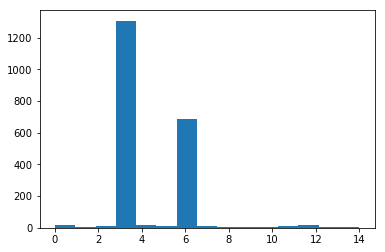

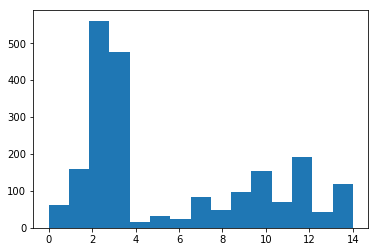

In [8]:
refit_mixture=True
if refit_mixture:
    mixture_beta = []
    n_classes = 15
    for i in range(Y_train.shape[1]-1):
        print("Fitting for task #{}".format(i))
        task_beta, task_assignments = baselines.mixture_model_logistic(
            X_train, np.expand_dims(Y_train[:, i], 1),
            n_classes=n_classes, lam=1e-3, n_restarts=5, verbosity=100,
            init_lr=2e-1, eps=1e-1)
        mixture_beta.append(task_beta)
        plt.figure()
        plt.hist(task_assignments, bins=n_classes)
    mixture_beta.append(np.zeros_like(mixture_beta[0]))
    mixture_beta = np.swapaxes(np.array(mixture_beta), 0, 1)
    np.save("beta_mixture.npy", mixture_beta)
else:
    mixture_beta = np.load("beta_mixture.npy")

In [9]:
print(mixture_beta.shape)
print(X_train.shape)

(2135, 3, 6)
(2135, 6)


In [10]:
train_preds_mix = np.array([np.tensordot(X_train[i], mixture_beta[i].T, axes=1) for i in range(len(X_train))])

In [11]:
print(train_preds_mix.shape)

(2135, 3)


In [12]:
print(train_preds_mix)

[[-0.205 -0.044  0.   ]
 [-0.205 -0.06   0.   ]
 [-0.351  0.9    0.   ]
 ...
 [-0.351  0.809  0.   ]
 [-0.351  0.9    0.   ]
 [-0.351  0.9    0.   ]]


In [13]:
print(Y_train)

[[0.472 0.519 0.009]
 [0.504 0.485 0.012]
 [0.252 0.743 0.005]
 ...
 [0.282 0.695 0.023]
 [0.293 0.699 0.008]
 [0.258 0.734 0.008]]


In [14]:
mapped_train_preds = np.exp(train_preds_mix) / (1 + np.exp(train_preds_mix))

In [15]:
from sklearn.metrics import mean_squared_error
a = mean_squared_error(Y_train[:, 0], mapped_train_preds[:, 0])
b = mean_squared_error(Y_train[:, 1], mapped_train_preds[:, 1])
print((a+b)/2)

0.01184846937364287


In [16]:
from sklearn.metrics import r2_score
a = r2_score(Y_train[:, 0], mapped_train_preds[:, 0])
b = r2_score(Y_train[:, 1], mapped_train_preds[:, 1])
print((a+b)/2)

0.43758509404344187


In [17]:
(logistic_loss, mixture_preds) = calc_test_err(mixture_beta, X_test, Y_test,
                                               delta_U_test_train, 1, np.ones((delta_U_test_train.shape[2])))

In [18]:
mapped_test_preds = np.exp(mixture_preds) / (1 + np.exp(mixture_preds))

In [19]:
a = mean_squared_error(Y_test[:, 0], mapped_test_preds[:, 0])
b = mean_squared_error(Y_test[:, 1], mapped_test_preds[:, 1])
print((a+b)/2)

a = r2_score(Y_test[:, 0], mapped_test_preds[:, 0])
b = r2_score(Y_test[:, 1], mapped_test_preds[:, 1])
print((a+b)/2)

0.0301693467761825
-0.5696919577567529


In [95]:
refit_vc = True
if refit_vc:
    vc_beta = []
    vc_z = []
    for i in range(Y_train.shape[1]-1):
        print("Fitting for task #{}".format(i))
        init_Z = np.zeros((Z_train.shape[1]+1, X_train.shape[1]))
        #init_Z[0, -1] = np.mean(Y_train[:, i]) # intercept
        task_beta, task_Z = baselines.vc_logistic(
            X_train, np.expand_dims(Y_train[:, i], 1),
            Z_train, lam=1e-5, lr=1e-4, verbosity=10,
            n_restarts=1, init_Z=init_Z, max_iters=10000)
        print(task_beta)
        print(task_Z)
        vc_z.append(task_Z)
        vc_beta.append(task_beta)
    vc_beta.append(np.zeros_like(vc_beta[0]))
    vc_beta = np.swapaxes(np.array(vc_beta), 0, 1)
    print(vc_beta.shape)
    np.save("beta_vc.npy", vc_beta)
else:
    vc_beta = np.load("beta_vc.npy")

Fitting for task #0
Fitting Varying Coefficients with Logistic Output.
Restart 1 of 1
Iteration: 0 Total Loss:0.693 Pred:0.693 l1:0.000
Iteration: 10 Total Loss:0.678 Pred:0.678 l1:0.000
Iteration: 20 Total Loss:0.672 Pred:0.672 l1:0.000
Iteration: 30 Total Loss:0.671 Pred:0.670 l1:0.000
Iteration: 40 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 50 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 60 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 70 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 80 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 90 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 100 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 110 Total Loss:0.670 Pred:0.670 l1:0.000
Iteration: 120 Total Loss:0.670 Pred:0.670 l1:0.000
Reached local minimum at iteration 128.
Took 6.640 seconds.
** New best solution **
Took 6.64 seconds
[[-0.003  0.     0.003  0.     0.    -0.439]
 [-0.003  0.     0.003  0.     0.    -0.439]
 [-0.003  0.     0.003  0.     0.    -0.439]
 ...
 [-0.00

(2135, 2)


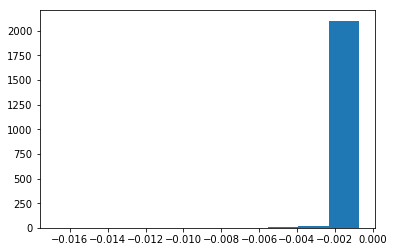

In [96]:
Z_bordered = np.hstack((Z_train, np.ones((len(Z_train), 1))))
print(Z_train.shape)
vc_beta = np.array([z.dot(vc_z) for z in Z_bordered])
vc_preds = np.array([X_train[i].dot(vc_beta[i].T) for i in range(len(X_train))])
plt.hist(vc_preds[:, 0])
plt.show()

In [97]:
calc_mse = lambda a,b,c,d,e,f: calc_test_err(a,b,c,d,e,f,mse=True, mae=False)

vc_preds_train = np.array([np.tensordot(X_train[i], vc_beta[i].T, axes=1) for i in range(len(X_train))])
mapped_vc_preds_train = np.exp(vc_preds_train / (1+vc_preds_train))

(vc_mse_test, vc_preds_test) = calc_mse(vc_beta, X_test, Y_test, delta_U_test_train, 1, np.ones((K)))
mapped_vc_preds_test = np.exp(vc_preds_test / (1+vc_preds_test))
#print(calc_mse(vc_beta, X_train, Y_train, delta_U_train_train, 1, np.ones((K))))

In [95]:
a = mean_squared_error(Y_train[:, 0], vc_preds_train[:, 0])
b = mean_squared_error(Y_train[:, 1], vc_preds_train[:, 1])
print(a, b, (a+b)/2)


a = mean_squared_error(Y_train[:, 0], mapped_vc_preds_train[:, 0])
b = mean_squared_error(Y_train[:, 1], mapped_vc_preds_train[:, 1])
print((a+b)/2)

a = r2_score(Y_train[:, 0], mapped_vc_preds_train[:, 0])
b = r2_score(Y_train[:, 1], mapped_vc_preds_train[:, 1])
print((a+b)/2)

[[-0.439  0.395  0.   ]
 [-0.439  0.395  0.   ]
 [-0.439  0.395  0.   ]
 ...
 [-0.439  0.395  0.   ]
 [-0.439  0.395  0.   ]
 [-0.439  0.395  0.   ]]
0.7116398722645113 0.06188901590981489 0.3867644440871631
0.2893965472868731
-12.888338461262324


In [81]:
a = mean_squared_error(Y_test[:, 0], mapped_vc_preds_test[:, 0])
b = mean_squared_error(Y_test[:, 1], mapped_vc_preds_test[:, 1])
print((a+b)/2)

a = r2_score(Y_test[:, 0], mapped_vc_preds_test[:, 0])
b = r2_score(Y_test[:, 1], mapped_vc_preds_test[:, 1])
print((a+b)/2)

0.2856080950759524
-13.82112365865072


In [24]:
# Baseline - overfit to intercept
N = X_train.shape[0]
P = X_train.shape[1]
T = vc_beta.shape[1]
overfit = np.zeros((N, T, P))
overfit[:, :, -1] = np.log(np.clip(Y_train, 0.01, 0.99))
print(overfit)

[[[ 0.     0.     0.     0.     0.    -0.75 ]
  [ 0.     0.     0.     0.     0.    -0.656]
  [ 0.     0.     0.     0.     0.    -4.605]]

 [[ 0.     0.     0.     0.     0.    -0.686]
  [ 0.     0.     0.     0.     0.    -0.724]
  [ 0.     0.     0.     0.     0.    -4.443]]

 [[ 0.     0.     0.     0.     0.    -1.378]
  [ 0.     0.     0.     0.     0.    -0.297]
  [ 0.     0.     0.     0.     0.    -4.605]]

 ...

 [[ 0.     0.     0.     0.     0.    -1.266]
  [ 0.     0.     0.     0.     0.    -0.364]
  [ 0.     0.     0.     0.     0.    -3.769]]

 [[ 0.     0.     0.     0.     0.    -1.228]
  [ 0.     0.     0.     0.     0.    -0.359]
  [ 0.     0.     0.     0.     0.    -4.605]]

 [[ 0.     0.     0.     0.     0.    -1.355]
  [ 0.     0.     0.     0.     0.    -0.31 ]
  [ 0.     0.     0.     0.     0.    -4.605]]]


In [26]:
# Baseline - Mean
base = np.zeros((N, 3, P))
base[:, :, -1] = np.mean(Y_train, axis=0)  # TODO: Should this be log?
print(base)

[[[0.    0.    0.    0.    0.    0.392]
  [0.    0.    0.    0.    0.    0.597]
  [0.    0.    0.    0.    0.    0.011]]

 [[0.    0.    0.    0.    0.    0.392]
  [0.    0.    0.    0.    0.    0.597]
  [0.    0.    0.    0.    0.    0.011]]

 [[0.    0.    0.    0.    0.    0.392]
  [0.    0.    0.    0.    0.    0.597]
  [0.    0.    0.    0.    0.    0.011]]

 ...

 [[0.    0.    0.    0.    0.    0.392]
  [0.    0.    0.    0.    0.    0.597]
  [0.    0.    0.    0.    0.    0.011]]

 [[0.    0.    0.    0.    0.    0.392]
  [0.    0.    0.    0.    0.    0.597]
  [0.    0.    0.    0.    0.    0.011]]

 [[0.    0.    0.    0.    0.    0.392]
  [0.    0.    0.    0.    0.    0.597]
  [0.    0.    0.    0.    0.    0.011]]]


In [20]:
#### Deep Learning benchmark.

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="the matrix subclass is")
import tensorflow as tf

Exception ignored in: <_io.FileIO name='/home/ben/.keras/keras.json' mode='rb'>


In [33]:
batch_size = 25

# Define a model with many linear regression atoms.
def xavier_init(fan_in, fan_out, constant=1):
    #Xavier initialization of network weights
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out + 1))
    return tf.random_uniform((fan_in, fan_out),
                             minval=low, maxval=high,
                             dtype=tf.float32)
try:
    tf.reset_default_graph()
except:
    pass

lr = 1e-4
lr_decay = 1-1e-4
learning_rate = tf.Variable(lr)

X_shape = X_train.shape[1] + Z_train.shape[1]
Y_shape = [3]

x = tf.placeholder(tf.float32, [None, X_shape])
y = tf.placeholder(tf.float32, [None, 3])

n_hidden = [250, 250, 250, 250]
eta_1 = tf.verify_tensor_all_finite(
    tf.Variable(tf.random_uniform(
        (X_shape, n_hidden[0]), minval=-1, maxval=1, dtype=tf.float32)),
    'eta_1 not finite')
b_1   = tf.Variable(tf.zeros([n_hidden[0]], dtype=tf.float32))
eta_2 = tf.verify_tensor_all_finite(
    tf.Variable(tf.random_uniform(
        (n_hidden[0], n_hidden[1]), minval=-1, maxval=1, dtype=tf.float32)),
    'eta_2 not finite')
b_2   = tf.Variable(tf.zeros([n_hidden[1]], dtype=tf.float32))
eta_3 = tf.verify_tensor_all_finite(
    tf.Variable(tf.random_uniform(
        (n_hidden[1], n_hidden[2]), minval=-1, maxval=1, dtype=tf.float32)),
    'eta_3 not finite')
b_3   = tf.Variable(tf.zeros(n_hidden[2], dtype=tf.float32))

eta_4 = tf.verify_tensor_all_finite(
    tf.Variable(tf.random_uniform(
        (n_hidden[2], n_hidden[3]), minval=-1, maxval=1, dtype=tf.float32)),
    'eta_4 not finite')
b_4   = tf.Variable(tf.zeros(n_hidden[3], dtype=tf.float32))

eta_5 = tf.verify_tensor_all_finite(
    tf.Variable(tf.random_uniform(
        (n_hidden[3], Y_shape[0]), minval=-1, maxval=1, dtype=tf.float32)),
    'eta_5 not finite')
b_5   = tf.Variable(tf.zeros(Y_shape, dtype=tf.float32))


hidden_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, eta_1), b_1))
hidden_2 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_1, eta_2), b_2))
hidden_3 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, eta_3), b_3))
hidden_4 = tf.nn.sigmoid(tf.add(tf.matmul(hidden_3, eta_4), b_4))
y_hat  = tf.add(tf.matmul(hidden_4, eta_5), b_5)

loss = tf.losses.mean_squared_error(y[:, 0], y_hat[:, 0]) + tf.losses.mean_squared_error(y[:, 1], y_hat[:, 1])
loss += 1e-2*tf.add_n([tf.nn.l2_loss(v) for v in [eta_1, eta_2, eta_3, eta_4] ])

In [34]:
optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(loss)

try:
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
except UserWarning:
    sess.close()
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)

In [35]:
n_epochs = 1000
XZ_train = np.hstack((X_train, Z_train))
print(X_train.shape)
print(XZ_train.shape)
learning_rate *= 2
print(sess.run((learning_rate)))
for i in range(n_epochs):
    learning_rate *= lr_decay
    permutation = np.random.permutation(len(X_train))
    total_cost = 0
    for idx in range(0, len(X_train)-batch_size, batch_size):
        start = idx
        end = idx + batch_size
        opt, cost, y_hat_val, eta_1_val = sess.run((optimizer, loss, y_hat, eta_1),
                                       feed_dict={
                                           x: XZ_train[permutation[start:end]],
                                           y: Y_train[permutation[start:end]]
                                       })
        total_cost += cost
        #print(y_hat_val, eta_1_val)#, Y_train[permutation[start:end]])
    print(i, total_cost)

(2135, 6)
(2135, 8)
0.0002
0 27612.020874023438
1 26864.06201171875
2 26859.478759765625
3 26854.92349243164
4 26850.365112304688
5 26845.791748046875
6 26841.233001708984
7 26836.662048339844
8 26832.094207763672
9 26827.53335571289
10 26822.97378540039
11 26818.41812133789
12 26813.855194091797
13 26809.292083740234
14 26804.747100830078
15 26800.154846191406
16 26795.63330078125
17 26791.077209472656
18 26786.51040649414
19 26781.963897705078
20 26777.394317626953
21 26772.855194091797
22 26768.313201904297
23 26763.74349975586
24 26759.202697753906
25 26754.663940429688
26 26750.12030029297
27 26745.56671142578
28 26741.019317626953
29 26736.47332763672
30 26731.92694091797
31 26727.37240600586
32 26722.844604492188
33 26718.308471679688
34 26713.751403808594
35 26709.200714111328
36 26704.673065185547
37 26700.14404296875
38 26695.574096679688
39 26691.062957763672
40 26686.53692626953
41 26681.9921875
42 26677.46356201172
43 26672.915802001953
44 26668.380126953125
45 26663.84863

366 25248.289459228516
367 25244.006439208984
368 25239.713500976562
369 25235.417205810547
370 25231.12777709961
371 25226.843231201172
372 25222.553771972656
373 25218.264190673828
374 25213.9716796875
375 25209.678619384766
376 25205.393524169922
377 25201.130828857422
378 25196.853942871094
379 25192.558135986328
380 25188.266998291016
381 25184.012664794922
382 25179.713470458984
383 25175.432983398438
384 25171.144989013672
385 25166.885681152344
386 25162.61376953125
387 25158.34423828125
388 25154.051971435547
389 25149.77554321289
390 25145.504119873047
391 25141.237335205078
392 25136.963104248047
393 25132.69744873047
394 25128.41421508789
395 25124.153747558594
396 25119.877716064453
397 25115.622192382812
398 25111.358123779297
399 25107.08514404297
400 25102.82681274414
401 25098.54278564453
402 25094.273681640625
403 25090.021911621094
404 25085.743774414062
405 25081.483947753906
406 25077.21762084961
407 25072.964141845703
408 25068.703094482422
409 25064.435913085938


730 23733.494689941406
731 23729.452087402344
732 23725.39810180664
733 23721.370971679688
734 23717.34649658203
735 23713.32763671875
736 23709.301879882812
737 23705.268432617188
738 23701.24346923828
739 23697.211486816406
740 23693.18685913086
741 23689.16421508789
742 23685.14047241211
743 23681.108123779297
744 23677.068786621094
745 23673.057067871094
746 23669.03970336914
747 23665.020904541016
748 23660.980102539062
749 23656.972717285156
750 23652.943237304688
751 23648.927459716797
752 23644.903900146484
753 23640.89535522461
754 23636.864471435547
755 23632.84878540039
756 23628.841766357422
757 23624.826538085938
758 23620.809631347656
759 23616.789794921875
760 23612.790252685547
761 23608.77374267578
762 23604.763549804688
763 23600.739379882812
764 23596.714965820312
765 23592.706146240234
766 23588.703979492188
767 23584.70166015625
768 23580.696166992188
769 23576.69171142578
770 23572.677032470703
771 23568.679809570312
772 23564.677856445312
773 23560.64453125
774 2

In [36]:
predictions_deep = sess.run((y_hat),
                           feed_dict={
                               x: np.hstack((X_train, Z_train))
                           })

test_predictions_deep = sess.run((y_hat),
                           feed_dict={
                               x: np.hstack((X_test, Z_test))
                           })

In [37]:
a = mean_squared_error(Y_train[:, 0], predictions_deep[:, 0])
b = mean_squared_error(Y_train[:, 1], predictions_deep[:, 1])
print(a, b, (a+b)/2)

a = mean_squared_error(Y_test[:, 0], test_predictions_deep[:, 0])
b = mean_squared_error(Y_test[:, 1], test_predictions_deep[:, 1])
print((a+b)/2)

a = r2_score(Y_test[:, 0], test_predictions_deep[:, 0])
b = r2_score(Y_test[:, 1], test_predictions_deep[:, 1])
print((a+b)/2)

0.021206223393398168 0.02047413703660869 0.02084018021500343
0.01913818530305638
0.0040428552072387935


In [90]:
T = 3
P = 6
beta_target = np.zeros((N_train, T, P))
init_beta = np.zeros_like(beta_target)#vc_beta[:N, :P]

lam = 1e-3
gamma = 1e3
alpha = 1e0
upsilon = 1e-2
inter_penalty = 0#2e0
l2_ratio = 1.0
rho_beta = lambda beta, i: lam*(functions.lasso_penalty(beta, beta_target[i])
                                + l2_ratio*functions.l2_penalty(beta, beta_target[i])
                               + inter_penalty*(beta[-1]**2))
rho_beta_prime = lambda beta, i:lam*(functions.lasso_derivative(beta, beta_target[i])
                                     + l2_ratio*functions.l2_prime(beta, beta_target[i])
                                    + 2*inter_penalty*np.vstack((np.zeros_like(beta[:-1]), beta[-1])))

init_phi_beta = np.hstack((utils.soft_normalize(np.ones((P*Y_train.shape[1])))))
psi_beta = lambda phi_beta: 0.5*alpha*np.linalg.norm(phi_beta - init_phi_beta, ord=2)
psi_beta_prime = lambda phi_beta: alpha*(phi_beta - init_phi_beta)

init_phi_u = utils.soft_normalize(np.ones((K)))
psi_u      = lambda phi_u: upsilon*np.linalg.norm(phi_u, ord=1)
psi_u_prime = lambda phi_u: upsilon*np.sign(phi_u)

init_beta_scale=1e2
psi_beta_scale = lambda beta_scale: 1e-3*(1./beta_scale)
psi_beta_scale_prime = lambda beta_scale: -1e-3*(beta_scale**(-2))


dmr = DistanceMatching(init_beta=init_beta,
                       f=lambda x, y, b: functions.logistic_loss_multitask(x, y, b.T),
                       f_prime= lambda x, y, b: functions.logistic_loss_prime_multitask(x, y, b),
                       gamma=gamma, n_neighbors=100, calc_dist_errors_every=1,
                       calc_closest_every=10,
                       rho_beta=rho_beta,
                       rho_beta_prime = rho_beta_prime,
                       init_phi_beta = init_phi_beta,
                       psi_beta = psi_beta,
                       psi_beta_prime = psi_beta_prime,
                       init_phi_u=init_phi_u,
                       psi_u=psi_u,
                       psi_u_prime=psi_u_prime,
                       init_beta_scale=init_beta_scale,
                       psi_beta_scale=psi_beta_scale,
                       psi_beta_scale_prime=psi_beta_scale_prime,
                       intercept=False, n_threads=0)

dZ = [
    lambda x,y: functions.safe_wrapper(x, y, functions.abs_diff)
]

for _ in range(K-1):
    dZ.append(lambda x,y: functions.safe_wrapper(x, y, functions.abs_diff))

In [91]:
print(init_beta.shape)

(2135, 3, 6)


In [93]:
if remake_delta_Z:
    delta_Z = dmr.make_covariate_distances(
        Z_train, dZ, len(dZ), len(Z_train), should_normalize=True)
    np.save("delta_Z.npy", delta_Z)
else:
    delta_Z = np.load("delta_Z.npy")

In [98]:
#print(vc_beta)
#print(X_train.shape)
#print(init_beta.shape)
init_beta_lr = vc_beta.swapaxes(1, 2)
init_beta_lr[:, :, -1] += np.random.uniform(0, 1, size=((init_beta_lr.shape[0], init_beta_lr.shape[1])))
print(init_beta_lr.shape)

gamma = 1e5
lam = 1e-2
beta_target = np.zeros_like(init_beta_lr)
rho_beta = lambda beta, i: lam*np.sum([
    functions.lasso_penalty(beta[:, j], beta_target[i, :, j])+
    functions.l2_penalty(beta[:, j], beta_target[i, :, j]) for j in range(beta.shape[1])])
rho_beta_prime = lambda beta, i: lam*(
    functions.lasso_derivative(beta, beta_target[i])+
    functions.l2_prime(beta, beta_target[i]))

(2135, 6, 2)


In [99]:
dmr_lr = DMR_LR(init_beta=init_beta_lr, #vc_beta
                            f=functions.linear_loss_multitask,
                            f_prime=functions.linear_loss_prime_multitask,
                            gamma=gamma,
                            latent_dim=2,
                            n_neighbors=5,
                            update_ztree_every=25,
                            calc_dist_errors_every=1,
                            calc_closest_every=2,
                            rho_beta=rho_beta,
                            rho_beta_prime = rho_beta_prime,
                            init_phi_u=init_phi_u,
                            psi_u=psi_u,
                            psi_u_prime=psi_u_prime,
                            intercept=False, log_dir="./", n_threads=1)
import sys
sys.setrecursionlimit(100000)
z_dmr_lr, b_dmr_lr = dmr_lr.fit(
    X_train, Y_train, Z_train, dZ, delta_U=delta_Z, init_lr=5e-7, lr_decay=1-1e-4,
    init_patience=25, verbosity=1, calc_neighbors=False, hierarchical=False)

Restart 1 of 1
No neighborhoods supplied. Will use random neighbors.


IndexError: index 2 is out of bounds for axis 1 with size 2

In [42]:
beta_hat_dmr_lr = np.tensordot(z_dmr_lr, b_dmr_lr, axes=1)
#print(dmr_lr.best_losses_over_time)
print(dmr_lr.best_phi_u)

print(dmr_lr.best_Z)
np.save("beta_har_dmr_lr_z.npy", dmr_lr.best_Z)

NameError: name 'z_dmr_lr' is not defined

In [17]:
print(X_train.shape)
print(Y_train.shape)
print(Z_train.shape)
print(delta_Z.shape)
print(len(dZ))
# 4:20 on 10/8 - Experimenting with extra neighbors: Had MSE < 0.03 with Neighbors = 50.
(beta_hat_dmr, phi_beta, phi_u, distances_over_time, losses_over_time) = dmr.fit(
    X_train, Y_train, Z_train, dZ, delta_U=delta_Z, init_lr=1e-3, tol=1e-3, lr_decay=1-1e-7,
    init_patience=25, verbosity=1, hierarchical=False)
# last experiment - 10x patience. previous result was 91% of MSE of mixture.
# Increasing to 25 mixtures seems to help mixtures without changing personalized.

(2135, 6)
(2135, 3)
(2135, 2)
(2135, 2135, 2)
2
Restart 1 of 1
No neighborhoods supplied. Will use random neighbors.
Reached local minimum at iteration 29.ion Took 3.981 seconds.
Took 123.229 seconds.
** New best solution **


In [ ]:
(beta_hat_dmr, phi_beta, phi_u, distances_over_time, losses_over_time) = dmr.fit(
    X_train, Y_train, Z_train, dZ, delta_U=delta_Z, init_lr=1e-3, tol=1e-3, lr_decay=1-1e-7,
    init_patience=25, verbosity=1, hierarchical=False)

[0.5 0.5]
[[ 3.411e-04  4.099e-04  1.829e-04 ...  2.535e-04  2.573e-04  1.945e-04]
 [-3.087e-04 -3.742e-04 -1.719e-04 ... -2.295e-04 -2.356e-04 -2.053e-04]
 [-3.371e-04 -4.013e-04 -1.650e-04 ... -2.451e-04 -2.458e-04 -2.023e-04]
 [ 3.564e-04  4.175e-04  1.650e-04 ...  2.498e-04  2.500e-04  1.833e-04]
 [-3.299e-04 -3.860e-04 -1.618e-04 ... -2.273e-04 -2.324e-04 -2.008e-04]
 [ 2.076e-01  2.062e-01  2.169e-01 ...  2.153e-01  2.151e-01  2.166e-01]]
[[-1.767e-04 -2.065e-04 -9.711e-05 ... -1.329e-04 -1.342e-04 -9.807e-05]
 [ 1.421e-04  1.683e-04  8.504e-05 ...  1.247e-04  1.284e-04  1.138e-04]
 [ 1.882e-04  2.063e-04  8.184e-05 ...  1.188e-04  1.189e-04  8.555e-05]
 [-1.752e-04 -2.079e-04 -8.446e-05 ... -1.241e-04 -1.242e-04 -9.305e-05]
 [ 1.452e-04  1.837e-04  7.876e-05 ...  1.200e-04  1.238e-04  1.079e-04]
 [ 3.868e-01  3.875e-01  3.822e-01 ...  3.827e-01  3.831e-01  3.823e-01]]
(2135, 3, 6)


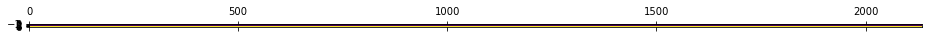

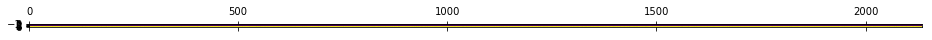

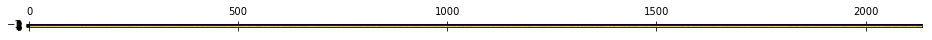

In [54]:
print(phi_u)
plt.matshow(np.abs(beta_hat_dmr[:, 0].T) > 1e-3)
plt.matshow(beta_hat_dmr[:, 1].T)
plt.matshow(beta_hat_dmr[:, 1].T - beta_hat_dmr[:, 0].T)
print(beta_hat_dmr[:, 1].T - beta_hat_dmr[:, 0].T)
print(beta_hat_dmr[:, 0].T)
print(beta_hat_dmr.shape)

In [80]:
beta_hat_dmr_lr = np.swapaxes(beta_hat_dmr_lr, 1, 2)

In [41]:
#print(Y_test - np.mean(Y_train, axis=0))
#plt.hist(Y_test - np.mean(Y_train, axis=0))
#plt.hist(np.square(Y_test[:, :2] - np.mean(Y_train, axis=0)[:2]))
phi_u = dmr_lr.best_phi_u

delta_U_train_train = np.ones((len(X_train), len(X_train), K))# - np.eye(len(X_train))
for i in range(len(X_train)):
    delta_U_train_train[i, i] = np.zeros((K))
calc_train_mse = lambda beta: calc_mse(beta, X_train, Y_train, delta_U_train_train, 1, np.ones_like(phi_u))

base_train_mse, base_preds = calc_train_mse(base)
overfit_train_mse, overfit_preds = calc_train_mse(overfit)
mix_train_mse, mix_preds  = calc_train_mse(mixture_beta)
vc_train_mse, vc_preds   = calc_train_mse(vc_beta)
#dmr_train_mse  = calc_train_mse(beta_hat_dmr)
dmr_lr_train_mse, dmr_lr_preds = calc_train_mse(beta_hat_dmr_lr)

print(overfit_preds)
print(dmr_lr_preds)

print("===== Train MSEs =====")
print("Mean:      {:.3f}".format(base_train_mse))
print("Overfit:   {:.3f}".format(overfit_train_mse))
print("Mixture:   {:.3f}".format(mix_train_mse))
print("Vc:        {:.3f}".format(vc_train_mse))
#print("DMR:     {}".format(dmr_train_mse))
print("DMR (LR):  {:.3f}".format(dmr_lr_train_mse))
#print(dmr_train_mse/vc_train_mse)


base_mse, base_preds = calc_mse(base, X_test, Y_test, delta_U_test_train, 1, np.ones_like(phi_u))
overfit_mse, overfit_preds = calc_mse(overfit, X_test, Y_test, delta_U_test_train, 1, np.ones_like(phi_u))
mix_mse, mix_preds = calc_mse(mixture_beta, X_test, Y_test, delta_U_test_train, 1, np.ones_like(phi_u))
vc_mse, vc_preds = calc_mse(vc_beta, X_test, Y_test, delta_U_test_train, 1, np.ones_like(phi_u))
#dmr_mse = calc_mse(beta_hat_dmr, X_test, Y_test, delta_U_test_train, 5, phi_u)
dmr_lr_mse, dmr_lr_preds = calc_mse(beta_hat_dmr_lr, X_test, Y_test, delta_U_test_train, 2, phi_u)


print("===== Test MSEs =====")
print("Mean:      {:.3f}".format(base_mse))
print("Overfit:   {:.3f}".format(overfit_mse))
print("Mixture:   {:.3f}".format(mix_mse))
print("Vc:        {:.3f}".format(vc_mse))
#print("DMR:     {}".format(dmr_mse))
print("DMR (LR):  {:.3f}".format(dmr_lr_mse))
#print(dmr_mse/vc_mse)

calc_mae = lambda a,b,c,d,e,f: calc_test_err(a,b,c,d,e,f,mse=False, mae=True)
calc_test_mae = lambda theta, n, phi: calc_mae(theta, X_test, Y_test, delta_U_test_train, n, phi)

base_mae, base_preds = calc_test_mae(base, 1, np.ones_like(phi_u))
overfit_mae, base_preds = calc_test_mae(overfit, 1, np.ones_like(phi_u))
mix_mae, base_preds = calc_test_mae(mixture_beta, 1, np.ones_like(phi_u))
vc_mae, base_preds = calc_test_mae(vc_beta, 1, np.ones_like(phi_u))
#dmr_mae = calc_mae(beta_hat_dmr, X_test, Y_test, delta_U_test_train, 5, phi_u)
dmr_lr_mae, base_preds = calc_test_mae(beta_hat_dmr_lr, 2, phi_u)
print("\n==== Test MAEs =====")
print("Mean:     {:.3f}".format(base_mae))
print("Overfit:  {:.3f}".format(overfit_mae))
print("Mixture:  {:.3f}".format(mix_mae))
print("VC:       {:.3f}".format(vc_mae))
#print("DMR:      {}".format(dmr_mae))
print("DMR (LR): {:.3f}".format(dmr_lr_mae))
#print(dmr_mae/mix_mae)

NameError: name 'dmr_lr' is not defined

In [69]:
# Sort and display MSE by increasing NN Dist 
np.save("beta_hat_dmr_lr.npy", beta_hat_dmr_lr)
np.save("phi_u.npy", phi_u)
np.save("phi_beta.npy", phi_beta)
np.save("beta_hat_vc.npy", vc_beta)

NameError: name 'phi_beta' is not defined

In [52]:
beta_hat_dmr_lr = np.load("beta_hat_dmr_lr.npy")
phi_u = np.load("phi_u.npy")

In [74]:
#print(np.argsort(np.abs((Z_test[0] - Z_train).dot(phi_u))))

beta_hat_dmr_test = np.array([
    np.mean(beta_hat_dmr_lr[np.argsort(np.abs((Z_test[i] - Z_train).dot(phi_u)))[:3]], axis=0)
    for i in range(len(X_test))])
print(beta_hat_dmr_test.shape)

(712, 3, 6)


In [80]:
dmr_preds_train = np.array([
    X_train[i].dot(beta_hat_dmr_lr[i].T) for i in range(len(X_train))
])
dmr_preds_test = np.array([
    X_test[i].dot(beta_hat_dmr_test[i].T) for i in range(len(X_test))
])

In [81]:
dmr_preds_train = np.exp(dmr_preds_train / (1+dmr_preds_train))
dmr_preds_test = np.exp(dmr_preds_test / (1+dmr_preds_test))
print(dmr_preds_train)
print(dmr_preds_test)

[[0.929 1.066 0.98 ]
 [1.038 0.96  0.987]
 [0.795 1.17  0.961]
 ...
 [0.805 1.163 1.077]
 [0.867 1.117 1.064]
 [0.893 1.097 1.039]]
[[0.86  1.123 1.021]
 [0.896 1.094 1.061]
 [0.965 1.034 1.024]
 ...
 [0.903 1.089 1.04 ]
 [0.946 1.051 0.983]
 [0.933 1.063 1.049]]


In [82]:
a = mean_squared_error(Y_train[:, 0], dmr_preds_train[:, 0])
b = mean_squared_error(Y_train[:, 1], dmr_preds_train[:, 1])
print(a, b, (a+b)/2)

a = mean_squared_error(Y_test[:, 0], dmr_preds_test[:, 0])
b = mean_squared_error(Y_test[:, 1], dmr_preds_test[:, 1])
print((a+b)/2)

a = r2_score(Y_test[:, 0], dmr_preds_test[:, 0])
b = r2_score(Y_test[:, 1], dmr_preds_test[:, 1])
print((a+b)/2)

0.2988295281789244 0.21521032376581592 0.25701992597237017
0.2730785224011241
-13.193309451765138


In [24]:
with open("results.txt", 'w') as result_file:
    print("{}\n".format(dmr_mse), file=result_file)
    print("{}\n".format(vc_mse), file=result_file)

print(beta_hat_dmr.shape)
delta_Z_test = dmr.make_covariate_distances(
        Z_test, dZ, len(dZ), len(Z_test), should_normalize=False)
N_test = len(delta_Z_test)
delta_Z_test = np.array([np.array([delta_Z_test[i, j].dot(phi_u) for j in range(N_test)]) for i in range(N_test)])

(2135, 3, 6)
Making Co-Variate Distance Matrix of Size 712x712x11


KeyboardInterrupt: 

In [396]:
nearest_neighbor_dists = np.amin(delta_Z_test, axis=0)
print(delta_Z_test)
print(nearest_neighbor_dists)

[[    0.      973.226  1683.586 ...  1177.297  1097.142 46845.354]
 [  973.226     0.     1926.495 ...   419.673   355.443 47260.973]
 [ 1683.586  1926.495     0.    ...  2331.287  1957.861 45467.598]
 ...
 [ 1177.297   419.673  2331.287 ...     0.      609.816 47587.732]
 [ 1097.142   355.443  1957.861 ...   609.816     0.    47119.617]
 [46845.354 47260.973 45467.598 ... 47587.732 47119.617     0.   ]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

(array([  0.,   0.,   0.,   0.,   0., 712.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

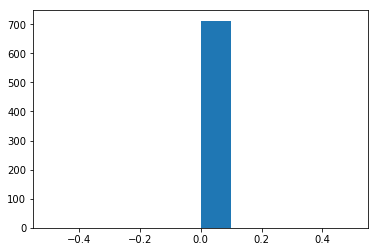

In [397]:
plt.hist(nearest_neighbor_dists)

In [28]:
print(phi_u)

[0.091 0.091 0.091 0.091 0.091 0.091 0.091 0.091 0.091 0.091 0.091]


In [29]:
print(phi_beta)

[0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016
 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016
 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016
 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016
 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016
 0.016 0.016 0.016]
